<a href="https://colab.research.google.com/github/AndrewCrossman/Graduate_Research/blob/main/G_g_p_p0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import csv
import numpy as np
from astropy.coordinates import cartesian_to_spherical
import pandas as pd
import scipy as sp
from scipy import optimize
from google.colab import files
import matplotlib.pylab as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.10/dist-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [102]:
def cartesian_to_spherical(x,y,z,lp):
    #takes x,y,z coords and lattice parameter
    x = x*lp
    y = y*lp
    z = z*lp
    r       =  np.sqrt((x*x + y*y + z*z))
    theta   =  np.arccos(z/r)*180/np.pi #to degrees
    phi     =  np.sign(y)*np.arccos(x/np.sqrt(x*x +y*y))*180/np.pi
    return [r,theta,phi]

In [103]:
file = "https://raw.githubusercontent.com/AndrewCrossman/Graduate_Research/main/Control/STRs/Sphere100_Au_onAu_r75_voidless.stru"
lattice_parameter = 4.0789

In [105]:
################################################################################
# Extract and Format data from "file_unrelaxed"
################################################################################
data1 = pd.read_csv(file, skiprows=4)
data1 = data1.drop(data1.columns[3:], axis=1)
data1[["atoms", "x"]] = data1[data1.columns[0]].str.split(expand=True)
data1 = data1.drop(data1.columns[0], axis=1)
data1 = data1.set_axis(["y", "z", "atom", "x"], axis=1, inplace=False)
data1["x"] = data1["x"].astype(float)
data1["y"] = data1["y"].astype(float)
data1["z"] = data1["z"].astype(float)
data1["distance"], data1["theta"], data1["phi"] = cartesian_to_spherical(data1["x"], data1["y"], data1["z"],1)
data1 = data1.rename(columns={"x":"x_base", "y":"y_base", "z":"z_base", "distance":"distance_base", "theta":"theta_base", "phi":"phi_base"})
data1 = data1[["atom","x_base", "y_base", "z_base", "distance_base", "theta_base", "phi_base"]]
data1

<ipython-input-105-f3d65b9a6c5f>:8: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  data1 = data1.set_axis(["y", "z", "atom", "x"], axis=1, inplace=False)


,atom,x_base,y_base,z_base,distance_base,theta_base,phi_base
0,AU,-1.0,-5.5,-17.5,18.371173,162.284528,-100.304846
1,AU,0.0,-5.5,-17.5,18.343936,162.552812,-90.000000
2,AU,1.0,-5.5,-17.5,18.371173,162.284528,-79.695154
3,AU,-3.0,-4.5,-17.5,18.316659,162.826380,-123.690068
4,AU,-2.5,-5.0,-17.5,18.371173,162.284528,-116.565051
...,...,...,...,...,...,...,...
104176,AU,-0.5,3.5,18.0,18.343936,11.112488,98.130102
104177,AU,0.0,3.0,18.0,18.248288,9.462322,90.000000
104178,AU,0.5,3.5,18.0,18.343936,11.112488,81.869898
104179,AU,1.0,3.0,18.0,18.275667,9.964161,71.565051


In [119]:
data1['distance_base'].value_counts()

17.930421    696
16.985288    672
18.124569    576
16.628289    576
16.077935    528
            ... 
8.000000       6
2.000000       6
4.000000       6
16.000000      6
0.000000       1
Name: distance_base, Length: 623, dtype: int64

In [125]:
#values,counts = [data1['distance_base'].value_counts().keys().tolist(), data1['distance_base'].value_counts().tolist()]
#counts = data1['distance_base'].value_counts().tolist()

dictionary = dict(zip(data1['distance_base'].value_counts().keys().tolist(), data1['distance_base'].value_counts().tolist()))
dictionary.keys()

dict_keys([17.930421077041107, 16.98528775146303, 18.12456896039186, 16.62828914831589, 16.077935190813527, 14.713938969562161, 16.80773631397161, 14.611639196202457, 15.700318468107582, 17.592612085759182, 17.84656829757475, 15.411035007422441, 16.170961628796228, 17.363755354185336, 17.507141400011598, 14.089002803605371, 18.179658962697843, 17.421251390184345, 18.371173070873837, 15.215124054702938, 17.24818831066034, 13.546217184144066, 14.543039572248986, 18.207141456033124, 17.67766952966369, 17.76231966833161, 18.096961070853858, 16.837458240482736, 16.718253497300488, 17.073371078963874, 16.355427233796124, 15.116216457830975, 15.732132722552274, 12.509996003196804, 15.604486534327235, 12.389511693363866, 14.230249470757707, 16.38596960817394, 13.322912594474229, 16.015617378046965, 10.559356040971437, 16.926310879810757, 13.095800853708795, 13.874436925511608, 12.186057606953941, 15.98436736314578, 17.790446874657196, 18.01388353465182, 17.621010186706094, 18.261982367749674, 

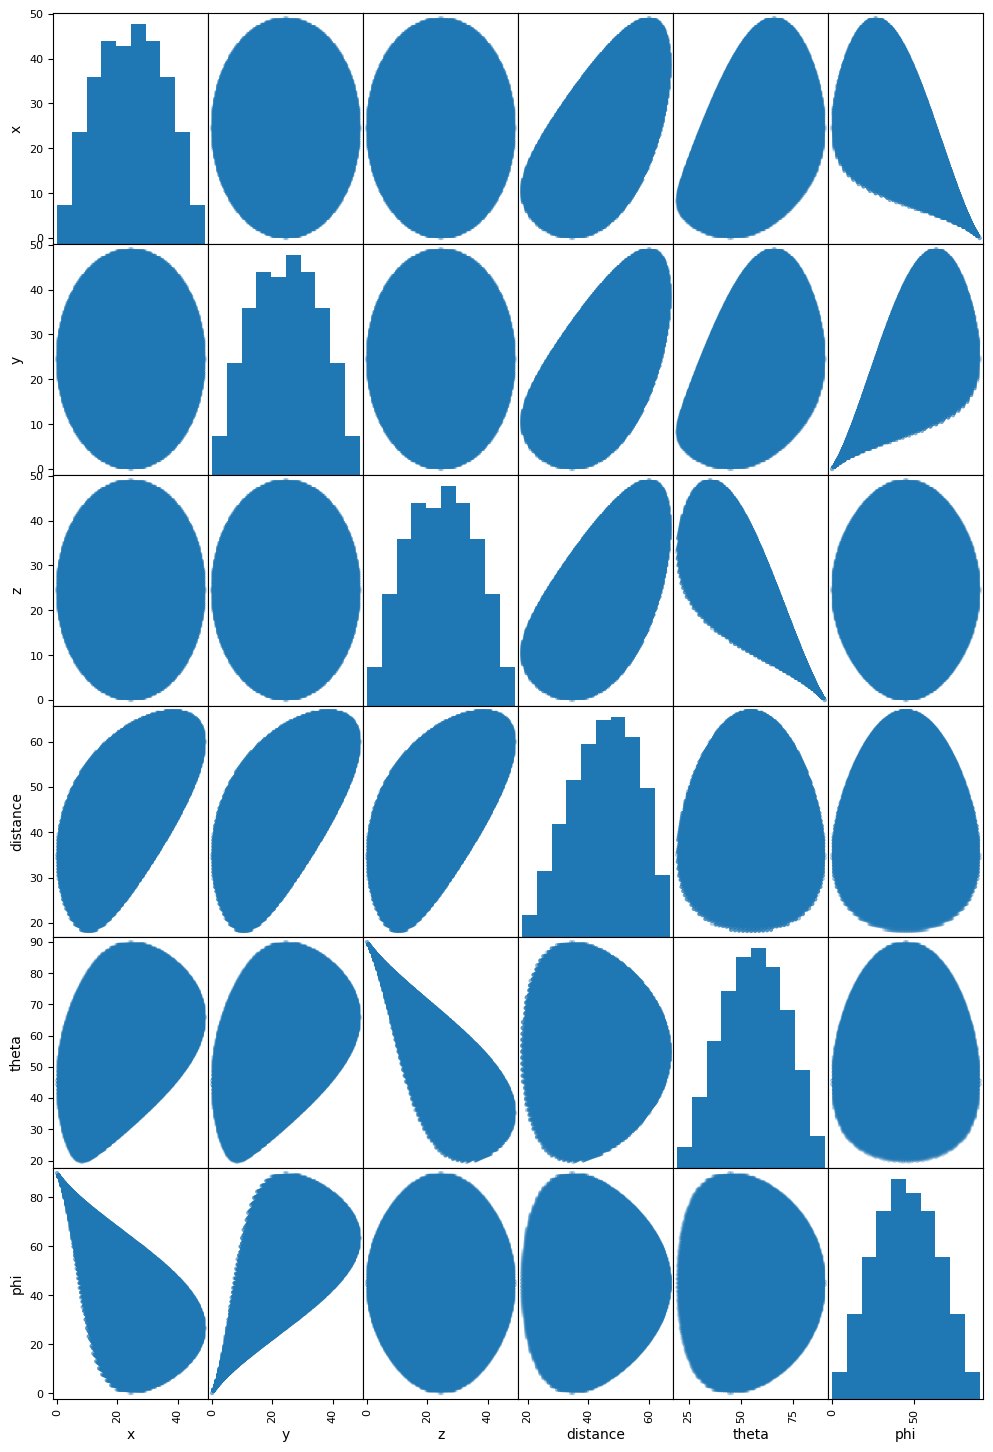

In [26]:
pd.plotting.scatter_matrix(data, alpha=.2, figsize=(12,18));